In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta'] # 中文輸出(台北黑體)
%matplotlib inline
import pickle

# pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', 100)

In [2]:
def color_code2cmp(code):
    r = int('0x'+code[1:3], 16)
    g = int('0x'+code[3:5], 16)
    b = int('0x'+code[5:], 16)
    
    vals = np.ones((256, 4))
    vals[:, 0] = np.linspace(1, r/256, 256)
    vals[:, 1] = np.linspace(1, g/256, 256)
    vals[:, 2] = np.linspace(1, b/256, 256)
    return matplotlib.colors.ListedColormap(vals)

def read_vote(file_path):
    cols = ['行政區別', '村里別', '宋', '韓', '蔡', '有效票數A', '無效票數B', '投票數C', '已領未投票數', '發出票數E', '用餘票數F', '選舉人數G', '投票率H']

    df = pd.read_excel(file_path)
    df = df.iloc[5:]
    df.columns = cols
    dft = df.T

    area = ''
    for i in dft:
        if type(dft[i]['村里別']) == float:
            area = dft[i]['行政區別'][1:]
        else:
            df['行政區別'][i] = area

    df = df[df['村里別'].notnull()]
    df['city'] = file_path[-8:-5]
    
    return df

In [3]:
df_lst = []
for f_p in os.listdir('總統票/'):
    if 'A05-3' in f_p:
        df_lst.append(read_vote('總統票/' + f_p))

In [4]:
# cols = ['city', '行政區別', '村里別', '宋', '韓', '蔡', '有效票數A', '無效票數B', '投票數C', '已領未投票數', '發出票數E', '用餘票數F', '選舉人數G', '投票率H']
cols = ['city', '行政區別', '村里別', '宋', '韓', '蔡']
data = pd.concat(df_lst).reset_index()[cols]

# 票數是字串 需要移除 ',' 並組合轉成 (int)
for p in ['宋', '韓', '蔡']: 
    data[p] = data[p].str.split(',').str.join('')
# 轉成int
data[['宋', '韓', '蔡']] = data[['宋', '韓', '蔡']].astype(int)
# 轉成每一里的比例
data[['宋', '韓', '蔡']] = (data[['宋', '韓', '蔡']].T / data[['宋', '韓', '蔡']].sum(1) * 100).T

### 兩村里一投票所的問題！

In [5]:
add_df = pd.DataFrame(columns=data.columns).T # 創造一個新df 來存取合併的里

ind = 0
for i in range(data.shape[0]):
    if '、' in data['村里別'][i]:
        lst = data['村里別'][i].split('、')
        new_lst = list(data.iloc[i].values)
        for area in lst:
            new_lst[2] = area
            add_df[ind] = new_lst
            ind += 1
        
    

data = pd.concat([data, add_df.T]) 
data = data[data['村里別'].str.find('、') == -1].reset_index()[data.columns]

# 轉成int
data[['宋', '韓', '蔡']] = data[['宋', '韓', '蔡']].astype(int)

### 資料完整 沒有空值

In [6]:
np.all(data.notnull())

True

### 讀取村里圖資料

In [7]:
tw3 = gp.read_file('tw村里圖資/VILLAGE_MOI_1081121.shp')
# 處理不相關資料
tw3 = tw3[['COUNTYNAME', 'TOWNNAME', 'VILLNAME', 'geometry']]
# 處理空值
# tw3 = tw3[np.all(tw3.notnull(), 1)].reset_index()[tw3.columns]

np.all(tw3.notnull())

False

### 發現無法對上的值

```python
s = set(data.村里別)
for li in list(tw3['VILLNAME']):
    if li not in s:
        print(li)
```

In [8]:
# 補上發現的缺值
tw3.loc[831, 'VILLNAME'] = '𦰡拔里'
tw3.loc[1027, 'VILLNAME'] = '石𥕢里'
tw3.loc[1193, 'VILLNAME'] = '瓊埔村'
tw3.loc[3482, 'VILLNAME'] = '台西村'
tw3.loc[5484, 'VILLNAME'] = '溝垻里'
tw3.loc[6176, 'VILLNAME'] = '石𥕢里'
tw3.loc[7078, 'VILLNAME'] = '濓新里'
tw3.loc[7081, 'VILLNAME'] = '濓洞里'

### 做出連結的KEY

In [9]:
data['key'] = data['city'] + data['行政區別'] + data['村里別']
tw3['key'] = tw3['COUNTYNAME'] + tw3['TOWNNAME'] + tw3['VILLNAME']
# layout = tw3.merge(data)
layout = pd.merge(tw3, data, how='outer') # 作弊因為有缺值

### 資料數量不同 需要處理

In [10]:
print(data.shape)
print(tw3.shape)
print(layout.shape)

(7771, 7)
(7965, 5)
(7992, 11)


### 政黨列表 顏色列表

In [11]:
cols = ['宋', '韓', '蔡']
party_name = ['親民黨', '國民黨', '民進黨'] # 政黨
c_lst = ['#ff6213', '#0008a7', '#009b1c'] # 色碼
tw1 = gp.read_file('tw縣市圖資///COUNTY_MOI_1081121.shp')
tw2 = gp.read_file('tw區鄉鎮圖資///TOWN_MOI_1081121.shp')

### 讓圖形顯示更清楚 (極值忽略)  and 補上平均值缺值

In [13]:
data_des = data[cols].describe([0.01, 0.99])

minval = data_des.loc['1%'].values
maxval = data_des.loc['99%'].values

for i, party in enumerate(['宋', '韓', '蔡']):
    layout[party] = layout[party].fillna(data[cols].mean().values[i]) # 缺值填入平均值
    layout[party] = np.maximum(np.minimum(layout[party], maxval[i]), minval[i])
  

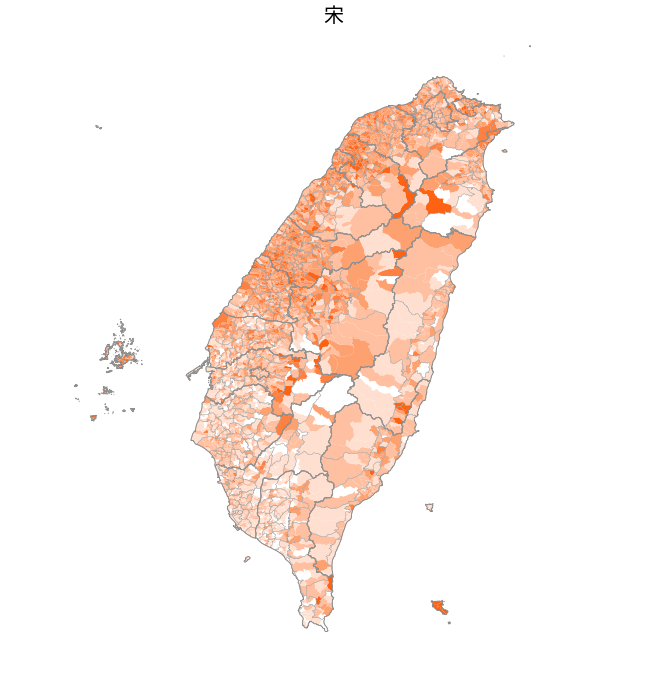

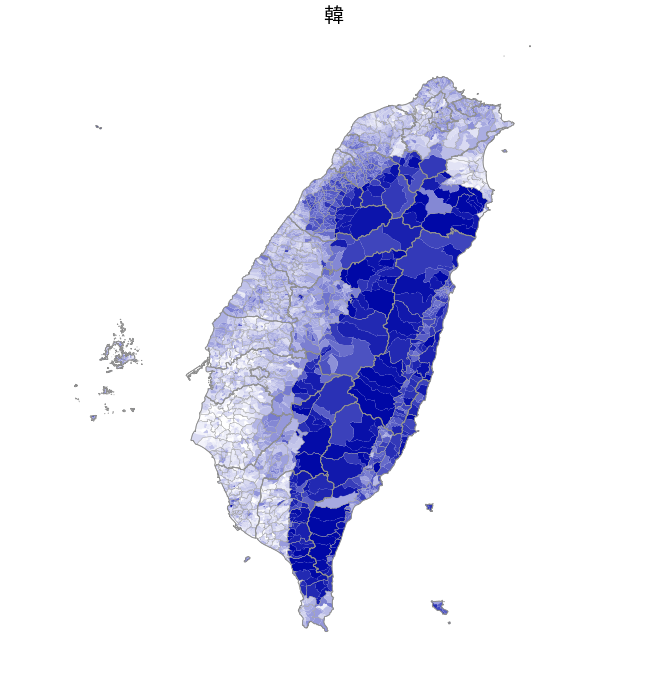

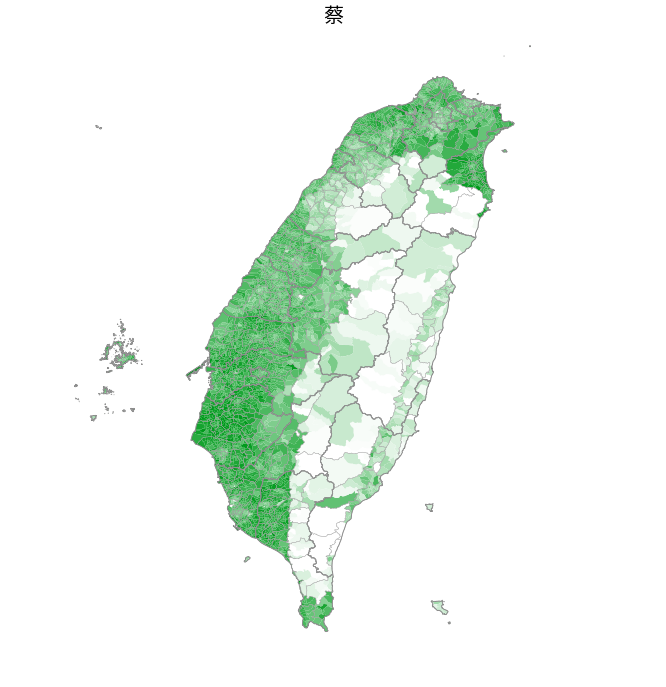

In [14]:
for i in range(3):
    cmp = color_code2cmp(c_lst[i])
    base = layout.plot(figsize=(12, 12), column=cols[i], cmap=cmp)
    tw1.plot(ax=base, fc='', edgecolor='#808080', rasterized=True, lw=0.9)
    tw2.plot(ax=base, fc='', edgecolor='#a0a0a0', rasterized=True, lw=0.3)
    plt.title(cols[i], fontsize=20)
    
    d = 4
    x = 118.9
    plt.xlim(x, x+d)
    y = 21.6
    plt.ylim(y, y+d)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.box(0)
    plt.show()